# Simple q-learning agent with experience replay

We re-write q-learning algorithm using _agentnet_ - a helper for lasagne that implements some RL techniques.

In [7]:
! pip install --upgrade https://github.com/yandexdataschool/AgentNet/archive/master.zip

     - 11.7MB 1.1MB/s
Requirement already up-to-date: six in /home/kirill/.local/lib/python2.7/site-packages (from agentnet==0.10.6)
Requirement already up-to-date: numpy>=1.9 in /home/kirill/.local/lib/python2.7/site-packages (from agentnet==0.10.6)
  Using cached scipy-1.0.0-cp27-cp27mu-manylinux1_x86_64.whl
  Found existing installation: scipy 0.19.1
    Uninstalling scipy-0.19.1:
      Successfully uninstalled scipy-0.19.1
  Running setup.py install for agentnet ... done


In [24]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
%env THEANO_FLAGS='floatX=float32'

#XVFB will be launched if you run on a server
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

env: THEANO_FLAGS='floatX=float32'


### Experiment setup
* Here we simply load the game and check that it works

In [25]:
import gym
make_env = lambda: gym.make("LunarLander-v2")

env=make_env()
env.reset()

state_shape = env.observation_space.shape
n_actions = env.action_space.n

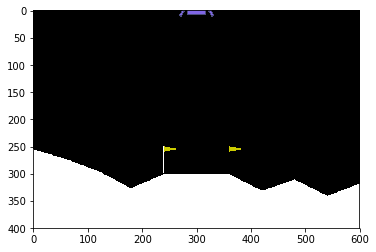

In [26]:
plt.imshow(env.render("rgb_array"))
del env

# Neural Network body

In [27]:
import theano
import lasagne
from lasagne.layers import *
from lasagne.nonlinearities import *


#image observation at current tick goes here, shape = (sample_i,x,y,color)
observation_layer = InputLayer((None,)+state_shape)

nn = DenseLayer(observation_layer, 200, nonlinearity=elu)
nn = DenseLayer(nn, 200, nonlinearity=elu)

#a layer that predicts Qvalues
qvalues_layer = DenseLayer(nn,num_units=n_actions,
                           nonlinearity=None,name="q-values")

Picking actions is done by yet another layer, that implements $ \epsilon$ -greedy policy

In [28]:
from agentnet.resolver import EpsilonGreedyResolver
action_layer = EpsilonGreedyResolver(qvalues_layer)

#set starting epsilon
action_layer.epsilon.set_value(np.float32(0.05))

### Agent

We define an agent entirely composed of a lasagne network:
* Observations as InputLayer(s)
* Actions as intermediate Layer(s)
* `policy_estimators` is "whatever else you want to keep track of"

Each parameter can be either one layer or a list of layers

In [38]:
from agentnet.agent import Agent
agent = Agent(observation_layers=observation_layer,
              action_layers=action_layer,
              policy_estimators=qvalues_layer,)

In [39]:
#Since it's a single lasagne network, one can get it's weights, output, etc
weights = lasagne.layers.get_all_params(action_layer,trainable=True)
weights

[W, b, W, b, q-values.W, q-values.b]

# Create and manage a pool of atari sessions to play with

* To make training more stable, we shall have an entire batch of game sessions each happening independent of others
* Why several parallel agents help training: http://arxiv.org/pdf/1602.01783v1.pdf
* Alternative approach: store more sessions: https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf

In [92]:
from agentnet.experiments.openai_gym.pool import EnvPool
pool = EnvPool(agent,make_env,n_games=1,max_size=10000)

In [93]:
%%time
#interact for 7 ticks
obs_log,action_log,reward_log,_,_,_  = pool.interact(5)


print('actions:',action_log)
print('rewards:',reward_log)

('actions:', array([[1, 1, 1, 1, 3]]))
('rewards:', array([[-0.50298191, -0.409856  , -0.28514893, -0.14191915,  0.        ]]))
CPU times: user 4 ms, sys: 16 ms, total: 20 ms
Wall time: 6.21 ms


In [94]:
#we'll train on rollouts of 10 steps (required by n-step algorithms and rnns later)
SEQ_LENGTH=10

#load first sessions (this function calls interact and stores sessions in the pool)

for _ in range(100):
    pool.update(SEQ_LENGTH)

# q-learning

We shall now define a function that replays recent game sessions and updates network weights

In [95]:
#get agent's Qvalues obtained via experience replay
replay = pool.experience_replay.sample_session_batch(100)
qvalues_seq = agent.get_sessions(
    replay,
    session_length=SEQ_LENGTH,
    experience_replay=True,
)[-1]


In [96]:
#loss for Qlearning = (Q(s,a) - (r+gamma*Q(s',a_max)))^2, like you implemented before in lasagne.

from agentnet.learning import qlearning
elwise_mse_loss = qlearning.get_elementwise_objective(qvalues_seq,
                                                      replay.actions[0],
                                                      replay.rewards,
                                                      replay.is_alive,
                                                      gamma_or_gammas=0.99,
                                                      n_steps=1,)

#compute mean loss over "alive" fragments
loss = elwise_mse_loss.sum() / replay.is_alive.sum()

In [97]:
#get weight updates
updates = lasagne.updates.adam(loss,weights,learning_rate=1e-4)

#compile train function
import theano
train_step = theano.function([],loss,updates=updates)

# Demo run

Play full session with an untrained agent

In [99]:
#for MountainCar-v0 evaluation session is cropped to 200 ticks
untrained_reward = pool.evaluate(save_path="./records",record_video=True)

Episode finished after 70 timesteps with reward=-576.763114675


In [100]:
#show video
from IPython.display import HTML
import os

video_names = list(filter(lambda s:s.endswith(".mp4"),os.listdir("./records/")))

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./records/"+video_names[-1])) #this may or may not be _last_ video. Try other indices

# Training loop

In [103]:
epoch_counter = 1 #starting epoch
rewards = {} #full game rewards
target_score = 0

In [105]:
from tqdm import trange

for i in trange(10000):    
    
    #play
    for _ in range(5):
        pool.update(SEQ_LENGTH,append=True)
    
    #train
    train_step()
    
    #update epsilon
    epsilon = 0.05 + 0.95*np.exp(-epoch_counter/1000.)
    action_layer.epsilon.set_value(np.float32(epsilon))
    
    #play a few games for evaluation
    if epoch_counter%100==0:
        rewards[epoch_counter] = np.mean(pool.evaluate(n_games=3,record_video=False))
        print("iter=%i\tepsilon=%.3f"%(epoch_counter,action_layer.epsilon.get_value(),))
        print("Current score(mean over %i) = %.3f"%(3,np.mean(rewards[epoch_counter])))
    
        if rewards[epoch_counter] >= target_score:
            print("You win!")
            break

    
    epoch_counter  +=1

    
# Time to drink some coffee!

  1%|          | 100/10000 [00:20<33:19,  4.95it/s]

Episode finished after 108 timesteps with reward=-402.39785782
Episode finished after 124 timesteps with reward=-477.157399279
Episode finished after 76 timesteps with reward=-401.645244538
iter=100	epsilon=0.910
Current score(mean over 3) = -427.067


  2%|▏         | 200/10000 [00:40<33:18,  4.90it/s]

Episode finished after 100 timesteps with reward=-218.606059117
Episode finished after 87 timesteps with reward=-153.458055149
Episode finished after 83 timesteps with reward=-210.301754073
iter=200	epsilon=0.828
Current score(mean over 3) = -194.122


  3%|▎         | 300/10000 [01:06<35:52,  4.51it/s]

Episode finished after 110 timesteps with reward=-124.720306735
Episode finished after 100 timesteps with reward=-515.49958591
Episode finished after 165 timesteps with reward=-102.486760469
iter=300	epsilon=0.754
Current score(mean over 3) = -247.569


  4%|▍         | 400/10000 [01:34<37:59,  4.21it/s]

Episode finished after 83 timesteps with reward=-340.635886132
Episode finished after 102 timesteps with reward=-467.327714406
Episode finished after 94 timesteps with reward=-167.44157566
iter=400	epsilon=0.687
Current score(mean over 3) = -325.135


  5%|▌         | 500/10000 [02:05<39:47,  3.98it/s]

Episode finished after 84 timesteps with reward=-527.644907558
Episode finished after 81 timesteps with reward=-236.626373285
Episode finished after 63 timesteps with reward=-265.521793697
iter=500	epsilon=0.626
Current score(mean over 3) = -343.264


  6%|▌         | 600/10000 [02:34<40:20,  3.88it/s]

Episode finished after 159 timesteps with reward=-545.768530012
Episode finished after 140 timesteps with reward=-344.315581896
Episode finished after 171 timesteps with reward=-370.445128542
iter=600	epsilon=0.571
Current score(mean over 3) = -420.176


  7%|▋         | 699/10000 [03:02<40:23,  3.84it/s]

Episode finished after 150 timesteps with reward=-617.675344665


  7%|▋         | 700/10000 [03:03<40:31,  3.82it/s]

Episode finished after 276 timesteps with reward=-520.147969678
Episode finished after 160 timesteps with reward=-517.834420346
iter=700	epsilon=0.522
Current score(mean over 3) = -551.886


  8%|▊         | 799/10000 [03:31<40:35,  3.78it/s]

Episode finished after 107 timesteps with reward=-587.641399394
Episode finished after 151 timesteps with reward=-339.320153566


  8%|▊         | 800/10000 [03:32<40:40,  3.77it/s]

Episode finished after 160 timesteps with reward=-204.57106142
iter=800	epsilon=0.477
Current score(mean over 3) = -377.178


  9%|▉         | 900/10000 [04:00<40:33,  3.74it/s]

Episode finished after 187 timesteps with reward=-523.192347531
Episode finished after 88 timesteps with reward=-594.807327959
Episode finished after 93 timesteps with reward=-284.478204603
iter=900	epsilon=0.436
Current score(mean over 3) = -467.493


 10%|▉         | 999/10000 [04:28<40:17,  3.72it/s]

Episode finished after 189 timesteps with reward=-604.222750978
Episode finished after 257 timesteps with reward=-396.007481422


 10%|█         | 1000/10000 [04:29<40:28,  3.71it/s]

Episode finished after 266 timesteps with reward=-434.580502226
iter=1000	epsilon=0.399
Current score(mean over 3) = -478.270


 11%|█         | 1099/10000 [05:00<40:35,  3.66it/s]

Episode finished after 106 timesteps with reward=-272.037960311
Episode finished after 170 timesteps with reward=-318.406843155


 11%|█         | 1100/10000 [05:01<40:37,  3.65it/s]

Episode finished after 161 timesteps with reward=-756.053199254
iter=1100	epsilon=0.366
Current score(mean over 3) = -448.833


 12%|█▏        | 1199/10000 [05:33<40:49,  3.59it/s]

Episode finished after 295 timesteps with reward=-439.846018048
Episode finished after 215 timesteps with reward=-640.9889653


 12%|█▏        | 1200/10000 [05:34<40:55,  3.58it/s]

Episode finished after 109 timesteps with reward=-210.81873429
iter=1200	epsilon=0.336
Current score(mean over 3) = -430.551


 13%|█▎        | 1299/10000 [06:09<41:15,  3.52it/s]

Episode finished after 73 timesteps with reward=-471.552491377
Episode finished after 128 timesteps with reward=-351.694255663


 13%|█▎        | 1300/10000 [06:10<41:17,  3.51it/s]

Episode finished after 253 timesteps with reward=-322.725391736
iter=1300	epsilon=0.309
Current score(mean over 3) = -381.991


 14%|█▍        | 1399/10000 [06:44<41:29,  3.45it/s]

Episode finished after 202 timesteps with reward=-702.179798468
Episode finished after 180 timesteps with reward=-623.614948511


 14%|█▍        | 1400/10000 [06:46<41:34,  3.45it/s]

Episode finished after 216 timesteps with reward=-397.514114305
iter=1400	epsilon=0.284
Current score(mean over 3) = -574.436


 15%|█▍        | 1499/10000 [07:22<41:51,  3.38it/s]

Episode finished after 93 timesteps with reward=-332.491835683
Episode finished after 93 timesteps with reward=-405.51473953


 15%|█▌        | 1500/10000 [07:23<41:54,  3.38it/s]

Episode finished after 124 timesteps with reward=-520.56378346
iter=1500	epsilon=0.262
Current score(mean over 3) = -419.523


 16%|█▌        | 1599/10000 [07:58<41:54,  3.34it/s]

Episode finished after 155 timesteps with reward=-527.814378686
Episode finished after 114 timesteps with reward=-613.97677293


 16%|█▌        | 1600/10000 [07:59<41:58,  3.33it/s]

Episode finished after 132 timesteps with reward=-302.039280308
iter=1600	epsilon=0.242
Current score(mean over 3) = -481.277


 17%|█▋        | 1700/10000 [08:33<41:45,  3.31it/s]

Episode finished after 103 timesteps with reward=-572.163948413
Episode finished after 142 timesteps with reward=-440.518508754
Episode finished after 136 timesteps with reward=-177.377328222
iter=1700	epsilon=0.224
Current score(mean over 3) = -396.687


 18%|█▊        | 1799/10000 [09:06<41:31,  3.29it/s]

Episode finished after 227 timesteps with reward=-331.802935974
Episode finished after 212 timesteps with reward=-311.440884942


 18%|█▊        | 1800/10000 [09:09<41:42,  3.28it/s]

Episode finished after 274 timesteps with reward=-269.158655694
iter=1800	epsilon=0.207
Current score(mean over 3) = -304.134


 19%|█▉        | 1899/10000 [09:39<41:13,  3.28it/s]

Episode finished after 203 timesteps with reward=-308.911095789
Episode finished after 118 timesteps with reward=-121.072694219


 19%|█▉        | 1900/10000 [09:40<41:14,  3.27it/s]

Episode finished after 105 timesteps with reward=-120.272248076
iter=1900	epsilon=0.192
Current score(mean over 3) = -183.419


 20%|█▉        | 1999/10000 [10:06<40:27,  3.30it/s]

Episode finished after 253 timesteps with reward=-273.315418316


 20%|██        | 2000/10000 [10:07<40:30,  3.29it/s]

Episode finished after 360 timesteps with reward=-606.246774932
Episode finished after 213 timesteps with reward=-292.117206222
iter=2000	epsilon=0.179
Current score(mean over 3) = -390.560


 21%|██        | 2099/10000 [10:33<39:44,  3.31it/s]

Episode finished after 266 timesteps with reward=-414.312088068
Episode finished after 204 timesteps with reward=-318.778340053


 21%|██        | 2101/10000 [10:34<39:45,  3.31it/s]

Episode finished after 106 timesteps with reward=-278.636578051
iter=2100	epsilon=0.166
Current score(mean over 3) = -337.242


 22%|██▏       | 2199/10000 [10:59<38:57,  3.34it/s]

Episode finished after 99 timesteps with reward=-207.583372503
Episode finished after 232 timesteps with reward=-646.635955637


 22%|██▏       | 2201/10000 [11:00<38:59,  3.33it/s]

Episode finished after 241 timesteps with reward=-580.96009763
iter=2200	epsilon=0.155
Current score(mean over 3) = -478.393


 23%|██▎       | 2299/10000 [11:27<38:23,  3.34it/s]

Episode finished after 76 timesteps with reward=-430.332566354
Episode finished after 235 timesteps with reward=-405.27930311


 23%|██▎       | 2300/10000 [11:28<38:24,  3.34it/s]

Episode finished after 222 timesteps with reward=-470.63754205
iter=2300	epsilon=0.145
Current score(mean over 3) = -435.416


 24%|██▍       | 2400/10000 [11:56<37:47,  3.35it/s]

Episode finished after 184 timesteps with reward=-402.616163878
Episode finished after 93 timesteps with reward=-504.404850368
Episode finished after 121 timesteps with reward=-309.706131634
iter=2400	epsilon=0.136
Current score(mean over 3) = -405.576


 25%|██▍       | 2499/10000 [12:23<37:11,  3.36it/s]

Episode finished after 439 timesteps with reward=-223.50916627


 25%|██▌       | 2500/10000 [12:24<37:14,  3.36it/s]

Episode finished after 117 timesteps with reward=-93.7754422983
Episode finished after 100 timesteps with reward=-204.666754776
iter=2500	epsilon=0.128
Current score(mean over 3) = -173.984


 26%|██▌       | 2599/10000 [12:55<36:48,  3.35it/s]

Episode finished after 255 timesteps with reward=-365.050387575
Episode finished after 333 timesteps with reward=-249.657644232


 26%|██▌       | 2601/10000 [12:56<36:49,  3.35it/s]

Episode finished after 367 timesteps with reward=-368.983609029
iter=2600	epsilon=0.121
Current score(mean over 3) = -327.897


 27%|██▋       | 2699/10000 [13:13<35:46,  3.40it/s]

Episode finished after 299 timesteps with reward=-410.967796393
Episode finished after 184 timesteps with reward=-200.994907616


 27%|██▋       | 2701/10000 [13:14<35:46,  3.40it/s]

Episode finished after 169 timesteps with reward=-435.898276775
iter=2700	epsilon=0.114
Current score(mean over 3) = -349.287


 28%|██▊       | 2800/10000 [13:32<34:48,  3.45it/s]

Episode finished after 85 timesteps with reward=-234.944118125
Episode finished after 128 timesteps with reward=-292.280919337
Episode finished after 105 timesteps with reward=-113.995271473
iter=2800	epsilon=0.108
Current score(mean over 3) = -213.740


 29%|██▉       | 2899/10000 [13:53<34:02,  3.48it/s]

Episode finished after 115 timesteps with reward=-136.308021789
Episode finished after 226 timesteps with reward=-256.515002845


 29%|██▉       | 2901/10000 [13:54<34:02,  3.48it/s]

Episode finished after 79 timesteps with reward=-589.675531871
iter=2900	epsilon=0.102
Current score(mean over 3) = -327.500


 30%|███       | 3000/10000 [14:14<33:13,  3.51it/s]

Episode finished after 84 timesteps with reward=-806.059172919
Episode finished after 73 timesteps with reward=-282.698935292
Episode finished after 69 timesteps with reward=-505.470670281
iter=3000	epsilon=0.097
Current score(mean over 3) = -531.410


 31%|███       | 3099/10000 [14:35<32:30,  3.54it/s]

Episode finished after 213 timesteps with reward=-271.044868342
Episode finished after 79 timesteps with reward=-602.328810688


 31%|███       | 3100/10000 [14:38<32:34,  3.53it/s]

Episode finished after 101 timesteps with reward=-545.647456686
iter=3100	epsilon=0.093
Current score(mean over 3) = -473.007


 32%|███▏      | 3199/10000 [15:05<32:04,  3.53it/s]

Episode finished after 210 timesteps with reward=-723.922179105
Episode finished after 93 timesteps with reward=-232.957350668


 32%|███▏      | 3200/10000 [15:05<32:05,  3.53it/s]

Episode finished after 217 timesteps with reward=-609.691368797
iter=3200	epsilon=0.089
Current score(mean over 3) = -522.190


 33%|███▎      | 3300/10000 [15:23<31:14,  3.57it/s]

Episode finished after 230 timesteps with reward=-626.793758633
Episode finished after 176 timesteps with reward=-642.95023489
Episode finished after 78 timesteps with reward=-612.644355158
iter=3300	epsilon=0.085
Current score(mean over 3) = -627.463


 34%|███▍      | 3399/10000 [15:39<30:25,  3.62it/s]

Episode finished after 170 timesteps with reward=-929.61491076
Episode finished after 198 timesteps with reward=-1182.12903119

 34%|███▍      | 3401/10000 [15:40<30:25,  3.62it/s]


Episode finished after 182 timesteps with reward=-1160.77087272
iter=3400	epsilon=0.082
Current score(mean over 3) = -1090.838


 35%|███▍      | 3499/10000 [15:57<29:39,  3.65it/s]

Episode finished after 189 timesteps with reward=-285.894856787


 35%|███▌      | 3500/10000 [15:58<29:40,  3.65it/s]

Episode finished after 182 timesteps with reward=-682.511115575
Episode finished after 143 timesteps with reward=-486.112552801
iter=3500	epsilon=0.079
Current score(mean over 3) = -484.840


 36%|███▌      | 3599/10000 [16:20<29:04,  3.67it/s]

Episode finished after 98 timesteps with reward=-123.872408116


 36%|███▌      | 3600/10000 [16:21<29:04,  3.67it/s]

Episode finished after 153 timesteps with reward=-530.507568155
Episode finished after 102 timesteps with reward=-157.615858925
iter=3600	epsilon=0.076
Current score(mean over 3) = -270.665


 37%|███▋      | 3699/10000 [16:42<28:28,  3.69it/s]

Episode finished after 187 timesteps with reward=-525.35168033
Episode finished after 187 timesteps with reward=-627.403393828


 37%|███▋      | 3701/10000 [16:43<28:27,  3.69it/s]

Episode finished after 223 timesteps with reward=-575.386061981
iter=3700	epsilon=0.073
Current score(mean over 3) = -576.047


 38%|███▊      | 3799/10000 [17:03<27:50,  3.71it/s]

Episode finished after 97 timesteps with reward=-107.096830008


 38%|███▊      | 3800/10000 [17:05<27:53,  3.70it/s]

Episode finished after 80 timesteps with reward=-152.739883983
Episode finished after 71 timesteps with reward=-604.00253524
iter=3800	epsilon=0.071
Current score(mean over 3) = -287.946


 39%|███▉      | 3899/10000 [17:25<27:15,  3.73it/s]

Episode finished after 205 timesteps with reward=-360.506407061
Episode finished after 174 timesteps with reward=-266.479879484


 39%|███▉      | 3901/10000 [17:25<27:14,  3.73it/s]

Episode finished after 190 timesteps with reward=-602.761829471
iter=3900	epsilon=0.069
Current score(mean over 3) = -409.916


 40%|████      | 4000/10000 [17:44<26:36,  3.76it/s]

Episode finished after 102 timesteps with reward=-306.134803912
Episode finished after 105 timesteps with reward=-333.647631834
Episode finished after 88 timesteps with reward=-118.785718166
iter=4000	epsilon=0.067
Current score(mean over 3) = -252.856


 41%|████      | 4099/10000 [18:06<26:04,  3.77it/s]

Episode finished after 168 timesteps with reward=-436.943921115
Episode finished after 174 timesteps with reward=-292.825484023


 41%|████      | 4101/10000 [18:07<26:04,  3.77it/s]

Episode finished after 168 timesteps with reward=-247.387341991
iter=4100	epsilon=0.066
Current score(mean over 3) = -325.719


 42%|████▏     | 4200/10000 [18:29<25:31,  3.79it/s]

Episode finished after 201 timesteps with reward=-390.455483662
Episode finished after 114 timesteps with reward=-278.345559797
Episode finished after 134 timesteps with reward=-286.360269344
iter=4200	epsilon=0.064
Current score(mean over 3) = -318.387


 43%|████▎     | 4300/10000 [18:47<24:54,  3.82it/s]

Episode finished after 76 timesteps with reward=-210.484515115
Episode finished after 81 timesteps with reward=-489.075613254
Episode finished after 79 timesteps with reward=-485.643078186
iter=4300	epsilon=0.063
Current score(mean over 3) = -395.068


 44%|████▍     | 4400/10000 [19:06<24:19,  3.84it/s]

Episode finished after 90 timesteps with reward=-75.6109794617
Episode finished after 97 timesteps with reward=-122.494277668
Episode finished after 107 timesteps with reward=-307.699859485
iter=4400	epsilon=0.062
Current score(mean over 3) = -168.602


 45%|████▍     | 4499/10000 [19:26<23:46,  3.86it/s]

Episode finished after 92 timesteps with reward=-203.711408182
Episode finished after 95 timesteps with reward=-213.193016964


 45%|████▌     | 4500/10000 [19:27<23:46,  3.86it/s]

Episode finished after 90 timesteps with reward=-418.555881672
iter=4500	epsilon=0.061
Current score(mean over 3) = -278.487


 46%|████▌     | 4600/10000 [19:51<23:18,  3.86it/s]

Episode finished after 75 timesteps with reward=-61.9519579653
Episode finished after 129 timesteps with reward=-310.57701735
Episode finished after 114 timesteps with reward=-334.956982942
iter=4600	epsilon=0.060
Current score(mean over 3) = -235.829


 47%|████▋     | 4699/10000 [20:19<22:55,  3.85it/s]

Episode finished after 95 timesteps with reward=-253.094344552
Episode finished after 80 timesteps with reward=-203.272990146


 47%|████▋     | 4700/10000 [20:19<22:55,  3.85it/s]

Episode finished after 85 timesteps with reward=-474.398945874
iter=4700	epsilon=0.059
Current score(mean over 3) = -310.255


 48%|████▊     | 4799/10000 [20:42<22:26,  3.86it/s]

Episode finished after 70 timesteps with reward=-233.566630453
Episode finished after 82 timesteps with reward=-200.17760912


 48%|████▊     | 4800/10000 [20:42<22:26,  3.86it/s]

Episode finished after 88 timesteps with reward=-233.737585809
iter=4800	epsilon=0.058
Current score(mean over 3) = -222.494


 49%|████▉     | 4900/10000 [21:24<22:16,  3.82it/s]

Episode finished after 96 timesteps with reward=-332.502283556
Episode finished after 109 timesteps with reward=-244.604382234
Episode finished after 118 timesteps with reward=-341.78815519
iter=4900	epsilon=0.057
Current score(mean over 3) = -306.298


 50%|█████     | 5000/10000 [21:46<21:46,  3.83it/s]

Episode finished after 75 timesteps with reward=-432.288818753
Episode finished after 99 timesteps with reward=-59.9938008054
Episode finished after 67 timesteps with reward=-429.689330604
iter=5000	epsilon=0.056
Current score(mean over 3) = -307.324


 51%|█████     | 5100/10000 [22:10<21:18,  3.83it/s]

Episode finished after 67 timesteps with reward=-133.367465015
Episode finished after 76 timesteps with reward=-141.968791704
Episode finished after 61 timesteps with reward=-329.586305864
iter=5100	epsilon=0.056
Current score(mean over 3) = -201.641


 52%|█████▏    | 5199/10000 [22:43<20:58,  3.81it/s]

Episode finished after 87 timesteps with reward=-374.64974177
Episode finished after 63 timesteps with reward=-148.61863421


 52%|█████▏    | 5200/10000 [22:44<20:59,  3.81it/s]

Episode finished after 70 timesteps with reward=-357.426441836
iter=5200	epsilon=0.055
Current score(mean over 3) = -293.565


 53%|█████▎    | 5299/10000 [23:10<20:33,  3.81it/s]

Episode finished after 75 timesteps with reward=-307.75906193


 53%|█████▎    | 5300/10000 [23:11<20:33,  3.81it/s]

Episode finished after 91 timesteps with reward=-266.555184254
Episode finished after 81 timesteps with reward=-233.680979697
iter=5300	epsilon=0.055
Current score(mean over 3) = -269.332


 54%|█████▍    | 5399/10000 [23:41<20:11,  3.80it/s]

Episode finished after 106 timesteps with reward=-246.759175334
Episode finished after 85 timesteps with reward=-294.809908357


 54%|█████▍    | 5400/10000 [23:42<20:11,  3.80it/s]

Episode finished after 93 timesteps with reward=-192.780445409
iter=5400	epsilon=0.054
Current score(mean over 3) = -244.783


 55%|█████▍    | 5499/10000 [24:14<19:50,  3.78it/s]

Episode finished after 120 timesteps with reward=-293.868515587
Episode finished after 80 timesteps with reward=-118.139648325
Episode finished after 96 timesteps with reward=-308.206885927


 55%|█████▌    | 5500/10000 [24:15<19:50,  3.78it/s]

iter=5500	epsilon=0.054
Current score(mean over 3) = -240.072


 56%|█████▌    | 5600/10000 [24:43<19:25,  3.78it/s]

Episode finished after 80 timesteps with reward=-118.082217327
Episode finished after 100 timesteps with reward=-87.395972694
Episode finished after 87 timesteps with reward=-311.873706438
iter=5600	epsilon=0.054
Current score(mean over 3) = -172.451


 57%|█████▋    | 5699/10000 [25:10<18:59,  3.77it/s]

Episode finished after 80 timesteps with reward=-136.370465738
Episode finished after 115 timesteps with reward=-376.208971852


 57%|█████▋    | 5701/10000 [25:10<18:59,  3.77it/s]

Episode finished after 82 timesteps with reward=-147.088689949
iter=5700	epsilon=0.053
Current score(mean over 3) = -219.889


 58%|█████▊    | 5799/10000 [25:35<18:32,  3.78it/s]

Episode finished after 84 timesteps with reward=-279.632176418
Episode finished after 95 timesteps with reward=-183.596475432


 58%|█████▊    | 5800/10000 [25:36<18:32,  3.77it/s]

Episode finished after 128 timesteps with reward=-176.357378204
iter=5800	epsilon=0.053
Current score(mean over 3) = -213.195


 59%|█████▉    | 5900/10000 [26:05<18:07,  3.77it/s]

Episode finished after 158 timesteps with reward=-501.518871843
Episode finished after 97 timesteps with reward=-243.726853087
Episode finished after 197 timesteps with reward=-198.539550389
iter=5900	epsilon=0.053
Current score(mean over 3) = -314.595


 60%|██████    | 6000/10000 [26:28<17:38,  3.78it/s]

Episode finished after 74 timesteps with reward=-99.9540898707
Episode finished after 103 timesteps with reward=-13.5439093372
Episode finished after 92 timesteps with reward=-144.077084805
iter=6000	epsilon=0.052
Current score(mean over 3) = -85.858


 61%|██████    | 6100/10000 [26:52<17:11,  3.78it/s]

Episode finished after 84 timesteps with reward=-177.101877091
Episode finished after 89 timesteps with reward=-253.116162227
Episode finished after 87 timesteps with reward=-115.771125065
iter=6100	epsilon=0.052
Current score(mean over 3) = -181.996


 62%|██████▏   | 6199/10000 [27:20<16:45,  3.78it/s]

Episode finished after 145 timesteps with reward=-240.082680363
Episode finished after 83 timesteps with reward=-125.664594823


 62%|██████▏   | 6200/10000 [27:21<16:45,  3.78it/s]

Episode finished after 76 timesteps with reward=-122.869702664
iter=6200	epsilon=0.052
Current score(mean over 3) = -162.872


 63%|██████▎   | 6299/10000 [27:49<16:20,  3.77it/s]

Episode finished after 139 timesteps with reward=-151.809792758


 63%|██████▎   | 6300/10000 [27:50<16:20,  3.77it/s]

Episode finished after 108 timesteps with reward=-371.029368635
Episode finished after 104 timesteps with reward=-294.599210612
iter=6300	epsilon=0.052
Current score(mean over 3) = -272.479


 64%|██████▍   | 6399/10000 [28:17<15:55,  3.77it/s]

Episode finished after 191 timesteps with reward=-369.719168568
Episode finished after 168 timesteps with reward=-365.1021172


 64%|██████▍   | 6401/10000 [28:18<15:55,  3.77it/s]

Episode finished after 120 timesteps with reward=-271.307070078
iter=6400	epsilon=0.052
Current score(mean over 3) = -335.376


 65%|██████▍   | 6499/10000 [28:39<15:26,  3.78it/s]

Episode finished after 120 timesteps with reward=-97.8888471735
Episode finished after 201 timesteps with reward=-302.837676597


 65%|██████▌   | 6500/10000 [28:40<15:26,  3.78it/s]

Episode finished after 112 timesteps with reward=-245.220195161
iter=6500	epsilon=0.051
Current score(mean over 3) = -215.316


 66%|██████▌   | 6599/10000 [29:03<14:58,  3.79it/s]

Episode finished after 124 timesteps with reward=-348.268489762
Episode finished after 98 timesteps with reward=-86.3581428972


 66%|██████▌   | 6600/10000 [29:04<14:58,  3.78it/s]

Episode finished after 96 timesteps with reward=-171.606567429
iter=6600	epsilon=0.051
Current score(mean over 3) = -202.078


 67%|██████▋   | 6700/10000 [29:38<14:35,  3.77it/s]

Episode finished after 110 timesteps with reward=-352.285943496
Episode finished after 101 timesteps with reward=-317.892566005
Episode finished after 112 timesteps with reward=-71.7745562432
iter=6700	epsilon=0.051
Current score(mean over 3) = -247.318


 68%|██████▊   | 6799/10000 [30:07<14:11,  3.76it/s]

Episode finished after 102 timesteps with reward=-285.621882052
Episode finished after 79 timesteps with reward=-112.124921052


 68%|██████▊   | 6800/10000 [30:08<14:11,  3.76it/s]

Episode finished after 118 timesteps with reward=-231.00174441
iter=6800	epsilon=0.051
Current score(mean over 3) = -209.583


 69%|██████▉   | 6900/10000 [30:33<13:43,  3.76it/s]

Episode finished after 121 timesteps with reward=-283.238247688
Episode finished after 104 timesteps with reward=-259.028666522
Episode finished after 144 timesteps with reward=-233.61683355
iter=6900	epsilon=0.051
Current score(mean over 3) = -258.628


 70%|███████   | 7000/10000 [30:59<13:16,  3.76it/s]

Episode finished after 179 timesteps with reward=-364.483282872
Episode finished after 128 timesteps with reward=-175.122171976
Episode finished after 136 timesteps with reward=-72.5556711422
iter=7000	epsilon=0.051
Current score(mean over 3) = -204.054


 71%|███████   | 7100/10000 [31:25<12:50,  3.76it/s]

Episode finished after 99 timesteps with reward=-243.596084448
Episode finished after 121 timesteps with reward=-164.511787291
Episode finished after 131 timesteps with reward=-209.577663882
iter=7100	epsilon=0.051
Current score(mean over 3) = -205.895


 72%|███████▏  | 7200/10000 [31:52<12:23,  3.77it/s]

Episode finished after 172 timesteps with reward=-319.424254144
Episode finished after 141 timesteps with reward=-408.404852751
Episode finished after 115 timesteps with reward=-214.05753923
iter=7200	epsilon=0.051
Current score(mean over 3) = -313.962


 73%|███████▎  | 7300/10000 [32:17<11:56,  3.77it/s]

Episode finished after 138 timesteps with reward=-247.037722192
Episode finished after 114 timesteps with reward=-122.220993112
Episode finished after 180 timesteps with reward=-283.167220453
iter=7300	epsilon=0.051
Current score(mean over 3) = -217.475


 74%|███████▍  | 7400/10000 [32:42<11:29,  3.77it/s]

Episode finished after 124 timesteps with reward=-346.85106792
Episode finished after 160 timesteps with reward=-244.697214671
Episode finished after 145 timesteps with reward=-217.617988014
iter=7400	epsilon=0.051
Current score(mean over 3) = -269.722


 75%|███████▍  | 7499/10000 [33:07<11:02,  3.77it/s]

Episode finished after 133 timesteps with reward=-198.663802656
Episode finished after 128 timesteps with reward=-262.188860206


 75%|███████▌  | 7500/10000 [33:08<11:02,  3.77it/s]

Episode finished after 186 timesteps with reward=-253.921035579
iter=7500	epsilon=0.051
Current score(mean over 3) = -238.258


 76%|███████▌  | 7599/10000 [33:32<10:35,  3.78it/s]

Episode finished after 187 timesteps with reward=-276.026427745
Episode finished after 173 timesteps with reward=-242.733367425


 76%|███████▌  | 7600/10000 [33:33<10:35,  3.77it/s]

Episode finished after 161 timesteps with reward=-175.161231586
iter=7600	epsilon=0.050
Current score(mean over 3) = -231.307


 77%|███████▋  | 7699/10000 [33:59<10:09,  3.77it/s]

Episode finished after 196 timesteps with reward=-279.084446694
Episode finished after 213 timesteps with reward=-317.588239235


 77%|███████▋  | 7700/10000 [34:00<10:09,  3.77it/s]

Episode finished after 179 timesteps with reward=-202.635200015
iter=7700	epsilon=0.050
Current score(mean over 3) = -266.436


 78%|███████▊  | 7799/10000 [34:27<09:43,  3.77it/s]

Episode finished after 202 timesteps with reward=-277.919120637
Episode finished after 153 timesteps with reward=-246.490315043


 78%|███████▊  | 7801/10000 [34:28<09:42,  3.77it/s]

Episode finished after 214 timesteps with reward=-254.50573231
iter=7800	epsilon=0.050
Current score(mean over 3) = -259.638


 79%|███████▉  | 7899/10000 [34:44<09:14,  3.79it/s]

Episode finished after 165 timesteps with reward=-298.418685277
Episode finished after 185 timesteps with reward=-278.448754108


 79%|███████▉  | 7901/10000 [34:44<09:13,  3.79it/s]

Episode finished after 213 timesteps with reward=-197.708812314
iter=7900	epsilon=0.050
Current score(mean over 3) = -258.192


 80%|███████▉  | 7999/10000 [35:00<08:45,  3.81it/s]

Episode finished after 239 timesteps with reward=-212.998581725
Episode finished after 235 timesteps with reward=-263.572661437


 80%|████████  | 8001/10000 [35:01<08:44,  3.81it/s]

Episode finished after 164 timesteps with reward=-164.399786575
iter=8000	epsilon=0.050
Current score(mean over 3) = -213.657


 81%|████████  | 8099/10000 [35:15<08:16,  3.83it/s]

Episode finished after 189 timesteps with reward=-183.478132657
Episode finished after 113 timesteps with reward=-274.577828791


 81%|████████  | 8101/10000 [35:16<08:16,  3.83it/s]

Episode finished after 203 timesteps with reward=-370.954793828
iter=8100	epsilon=0.050
Current score(mean over 3) = -276.337


 82%|████████▏ | 8199/10000 [35:29<07:47,  3.85it/s]

Episode finished after 132 timesteps with reward=-182.316058522


 82%|████████▏ | 8200/10000 [35:30<07:47,  3.85it/s]

Episode finished after 298 timesteps with reward=-422.375731496
Episode finished after 183 timesteps with reward=-189.381528266
iter=8200	epsilon=0.050
Current score(mean over 3) = -264.691


 83%|████████▎ | 8299/10000 [35:51<07:21,  3.86it/s]

Episode finished after 210 timesteps with reward=-205.624513673
Episode finished after 116 timesteps with reward=-223.050572107


 83%|████████▎ | 8301/10000 [35:52<07:20,  3.86it/s]

Episode finished after 204 timesteps with reward=-356.355952027
iter=8300	epsilon=0.050
Current score(mean over 3) = -261.677


 84%|████████▍ | 8399/10000 [36:25<06:56,  3.84it/s]

Episode finished after 123 timesteps with reward=-324.539826649
Episode finished after 133 timesteps with reward=-146.354280173


 84%|████████▍ | 8400/10000 [36:27<06:56,  3.84it/s]

Episode finished after 157 timesteps with reward=-193.128711253
iter=8400	epsilon=0.050
Current score(mean over 3) = -221.341


 85%|████████▍ | 8499/10000 [36:56<06:31,  3.84it/s]

Episode finished after 129 timesteps with reward=-252.017251447
Episode finished after 164 timesteps with reward=-148.422608173


 85%|████████▌ | 8500/10000 [36:56<06:31,  3.83it/s]

Episode finished after 204 timesteps with reward=-136.193129397
iter=8500	epsilon=0.050
Current score(mean over 3) = -178.878


 86%|████████▌ | 8599/10000 [37:15<06:04,  3.85it/s]

Episode finished after 234 timesteps with reward=-213.149203236
Episode finished after 205 timesteps with reward=-115.172145668


 86%|████████▌ | 8601/10000 [37:17<06:03,  3.84it/s]

Episode finished after 226 timesteps with reward=-247.38596981
iter=8600	epsilon=0.050
Current score(mean over 3) = -191.902


 87%|████████▋ | 8699/10000 [37:33<05:36,  3.86it/s]

Episode finished after 163 timesteps with reward=-170.502089484
Episode finished after 187 timesteps with reward=-174.352503565


 87%|████████▋ | 8701/10000 [37:33<05:36,  3.86it/s]

Episode finished after 211 timesteps with reward=-112.204636722
iter=8700	epsilon=0.050
Current score(mean over 3) = -152.353


 88%|████████▊ | 8800/10000 [37:55<05:10,  3.87it/s]

Episode finished after 187 timesteps with reward=-359.766782181
Episode finished after 113 timesteps with reward=-166.282449724
Episode finished after 151 timesteps with reward=-149.300752221
iter=8800	epsilon=0.050
Current score(mean over 3) = -225.117


 89%|████████▉ | 8900/10000 [38:14<04:43,  3.88it/s]

Episode finished after 212 timesteps with reward=-145.221478903
Episode finished after 144 timesteps with reward=-77.2963570563
Episode finished after 124 timesteps with reward=-232.381163176
iter=8900	epsilon=0.050
Current score(mean over 3) = -151.633


 90%|████████▉ | 8999/10000 [38:30<04:16,  3.90it/s]

Episode finished after 183 timesteps with reward=-225.921507377
Episode finished after 147 timesteps with reward=-190.452231681


 90%|█████████ | 9001/10000 [38:31<04:16,  3.89it/s]

Episode finished after 158 timesteps with reward=-345.055385168
iter=9000	epsilon=0.050
Current score(mean over 3) = -253.810


 91%|█████████ | 9099/10000 [38:49<03:50,  3.91it/s]

Episode finished after 128 timesteps with reward=-313.90745445
Episode finished after 166 timesteps with reward=-386.034071865


 91%|█████████ | 9101/10000 [38:50<03:50,  3.91it/s]

Episode finished after 134 timesteps with reward=-281.872902921
iter=9100	epsilon=0.050
Current score(mean over 3) = -327.271


 92%|█████████▏| 9199/10000 [39:10<03:24,  3.91it/s]

Episode finished after 177 timesteps with reward=-250.796005041


 92%|█████████▏| 9200/10000 [39:11<03:24,  3.91it/s]

Episode finished after 190 timesteps with reward=-91.1224961296
Episode finished after 159 timesteps with reward=-89.0125668699
iter=9200	epsilon=0.050
Current score(mean over 3) = -143.644


 93%|█████████▎| 9299/10000 [39:29<02:58,  3.92it/s]

Episode finished after 124 timesteps with reward=-209.723324135
Episode finished after 175 timesteps with reward=-294.472337087


 93%|█████████▎| 9301/10000 [39:30<02:58,  3.92it/s]

Episode finished after 200 timesteps with reward=-261.938471504
iter=9300	epsilon=0.050
Current score(mean over 3) = -255.378


 94%|█████████▍| 9399/10000 [40:00<02:33,  3.92it/s]

Episode finished after 215 timesteps with reward=-224.521407531
Episode finished after 229 timesteps with reward=-200.543433155


 94%|█████████▍| 9400/10000 [40:00<02:33,  3.92it/s]

Episode finished after 169 timesteps with reward=-167.308501448
iter=9400	epsilon=0.050
Current score(mean over 3) = -197.458


 95%|█████████▍| 9499/10000 [40:27<02:08,  3.91it/s]

Episode finished after 201 timesteps with reward=-169.860277283
Episode finished after 251 timesteps with reward=-229.408867869


 95%|█████████▌| 9500/10000 [40:27<02:07,  3.91it/s]

Episode finished after 200 timesteps with reward=-67.2108453942
iter=9500	epsilon=0.050
Current score(mean over 3) = -155.493


 96%|█████████▌| 9599/10000 [40:54<01:42,  3.91it/s]

Episode finished after 260 timesteps with reward=-186.650987321


 96%|█████████▌| 9600/10000 [40:55<01:42,  3.91it/s]

Episode finished after 272 timesteps with reward=-206.422838596
Episode finished after 206 timesteps with reward=-156.217032186
iter=9600	epsilon=0.050
Current score(mean over 3) = -183.097


 97%|█████████▋| 9699/10000 [41:21<01:17,  3.91it/s]

Episode finished after 138 timesteps with reward=-47.1625022814
Episode finished after 300 timesteps with reward=-221.773101318


 97%|█████████▋| 9700/10000 [41:23<01:16,  3.91it/s]

Episode finished after 288 timesteps with reward=-206.054599577
iter=9700	epsilon=0.050
Current score(mean over 3) = -158.330


 98%|█████████▊| 9799/10000 [41:52<00:51,  3.90it/s]

Episode finished after 628 timesteps with reward=-232.287001448
Episode finished after 513 timesteps with reward=-254.986566499


 98%|█████████▊| 9800/10000 [41:55<00:51,  3.90it/s]

Episode finished after 321 timesteps with reward=-171.875114558
iter=9800	epsilon=0.050
Current score(mean over 3) = -219.716


 99%|█████████▉| 9899/10000 [42:25<00:25,  3.89it/s]

Episode finished after 647 timesteps with reward=-259.400259523
Episode finished after 900 timesteps with reward=-366.688521452


 99%|█████████▉| 9900/10000 [42:30<00:25,  3.88it/s]

Episode finished after 1000 timesteps with reward=-214.079483133
iter=9900	epsilon=0.050
Current score(mean over 3) = -280.056


100%|█████████▉| 9999/10000 [43:05<00:00,  3.87it/s]

Episode finished after 1000 timesteps with reward=-195.580779713
Episode finished after 1000 timesteps with reward=-183.922098613


100%|██████████| 10000/10000 [43:15<00:00,  3.85it/s]

Episode finished after 645 timesteps with reward=-219.62573046
iter=10000	epsilon=0.050
Current score(mean over 3) = -199.710


/home/kirill/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
  This is separate from the ipykernel package so we can avoid doing imports until


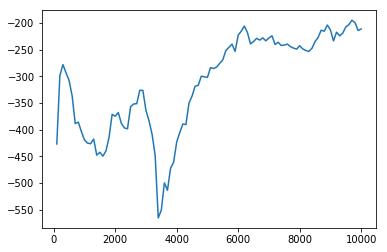

In [106]:
from pandas import ewma
iters,session_rewards=zip(*sorted(rewards.items(),key=lambda item:item[0]))
plt.plot(iters,ewma(np.array(session_rewards),span=10))

In [107]:
final_reward = pool.evaluate(n_games=10,save_path="./records",record_video=True)

print("average reward:",final_reward)

video_names = list(filter(lambda s:s.endswith(".mp4"),os.listdir("./records/")))

for video_name in video_names:
    HTML("""
    <video width="640" height="480" controls>
      <source src="{}" type="video/mp4">
    </video>
    """.format("./records/"+video_name)) #this may or may not be _last_ video. Try other indices

Episode finished after 1000 timesteps with reward=-166.811609045
Episode finished after 1000 timesteps with reward=-184.979596564
Episode finished after 1000 timesteps with reward=-212.056512488
Episode finished after 1000 timesteps with reward=-166.29234887
Episode finished after 1000 timesteps with reward=-189.565313199
Episode finished after 445 timesteps with reward=-163.834728391
Episode finished after 1000 timesteps with reward=-186.007294513
Episode finished after 1000 timesteps with reward=-189.234311853
Episode finished after 1000 timesteps with reward=-181.160740547
Episode finished after 1000 timesteps with reward=-158.127437599
('average reward:', [-166.81160904523071, -184.97959656376196, -212.05651248780507, -166.29234886963886, -189.56531319896996, -163.83472839137329, -186.00729451258837, -189.23431185282263, -181.16074054659018, -158.12743759854433])
